In [ ]:
!pip install librosa

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import os
import time

import torch
from torch.autograd import Variable

import librosa
import librosa.display
import numpy as np

import sys, inspect
sys.path.append("/audio")
# Use this if you want to include modules from a subfolder
# cmd_subfolder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],"../../../audio/")))
# if cmd_subfolder not in sys.path:
#     sys.path.insert(0, cmd_subfolder)
    
import torchaudio
#%matplotlib inline

# Estimate time it will take to generate spectrograms

We will be using mel-frequency cepstrum. 

> In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

>[A]pproximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

>Source: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

I was having a problem figuring out a way to identify the maximum frequency as is represented in our final spectrogram. In terms of creating the dataset, I think there could be problems where our outputs are biased based on the frequency range, and a classifier could learn these blank spaces at higher frequencies rather than the characteristics of the sounds we have recorded. So, I'm going to take a high window and then crop the image on import.

In [76]:
#test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/street_music/101848-9-0-0.wav"
#test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/children_playing/100263-2-0-117.wav"
test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/dog_bark/194754-3-0-1.wav"
#test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/dog_bark/100652-3-0-1.wav"
test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/dog_bark/100652-3-0-1.wav"
# 80589-0-0-2.wav
test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/children_playing/60935-2-0-9.wav"
#test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/children_playing/20688-2-0-1.wav"

In [77]:
import IPython.display as ipd
ipd.Audio(test_path)

In [45]:
time_log = 0

In [86]:
t0 = time.time()

# torchaudio.load() is 100x faster than librosa.load()
#sound_tensor, sr = librosa.load(test_path)
sound_tensor, sr = torchaudio.load(test_path)
duration = librosa.core.get_duration(sound_tensor.numpy()[:,0], sr=sr)
print(sr)
print(duration)

tn = time.time()
tt = tn-t0
time_log += tt
print(tt)

48000
4.0
0.003692150115966797


In [90]:
4 % 2

0

In [87]:
t0 = time.time()

# You could average the results:
# spect_input = (sound_tensor[:,0]+sound_tensor[:,1])/2
# spect_input = spect_input.numpy()

spect_input = sound_tensor.numpy()[:,0]
#fmax = 4000
#n_mels = 96 # CHOI et al.
#n_fft=2048
#hop_length=512
#power=2.0

denominator = 2
spect_input = spect_input[0:int(spect_input.shape[0]/denominator)]
#spect_input = test_crop
sr = sr*denominator

S = librosa.feature.melspectrogram(y=spect_input, sr=sr)

tn = time.time()
tt = tn-t0
time_log += tt
print(tt)

0.0281679630279541


In [83]:
sr

24000.0

0.1027536392211914


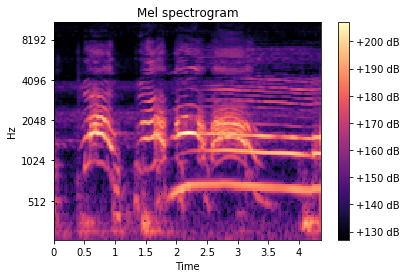

In [89]:
%matplotlib inline

t0 = time.time()

# ref = np.max(S)
# plt.ioff()
librosa.display.specshow(librosa.power_to_db(S),y_axis='mel',x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
#plt.axis('off') # Removes black border
#fig = plt.tight_layout()
# plt.savefig("../../test_output_spectrogram.png",bbox_inches='tight',pad_inches=-0.05,transparency=True)

# Now we can save it to a numpy array.
#fig = plt.figure()
#fig.canvas.draw()
#data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#plt.clf()
#plt.close()

tn = time.time()
tt = tn-t0
time_log += tt
print(tt)

In [ ]:
sound_tensor.numpy()[:,0] == sound_tensor.numpy()[:,1]

In [ ]:
test_crop = sound_tensor.numpy()[:,1]
test_crop = test_crop[0:24000]
spect_input = test_crop
sr_c = sr/4

In [ ]:
spect_input = test_crop
S = librosa.feature.melspectrogram(y=spect_input, sr=sr, n_fft=2048)

%matplotlib inline

# plt.ioff()
librosa.display.specshow(librosa.power_to_db(S,ref=ref),y_axis='mel',x_axis='time',sr=sr_c)

plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

In [ ]:
pitch, mag = librosa.core.pitch.piptrack(spect_input,sr,fmax=60000)
print(np.max(pitch))
print(np.max(mag)/60000)

In [ ]:
# Should take about a minute to convert all sounds into histograms
time_log

In [ ]:
%matplotlib inline
plt.imshow(data)

# Generate spectrograms for directory

This takes about 30 minutes.

In [2]:
def generate_spectrogram(sound_in, img_out):
    
    sound_tensor, sr = torchaudio.load(sound_in)
    y = sound_tensor.numpy()[:,0]
    #n_mels = 128*3 # perhaps twice as long as 128
    #fmax = 10000

    S = librosa.feature.melspectrogram(y=y, sr=sr)

    plt.ioff()
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max))
    plt.axis('off') # Removes black border
    plt.tight_layout()
    plt.savefig(img_out,bbox_inches='tight',pad_inches=-0.05,transparency=True, format='jpg')
    plt.clf() # clear figure to control memory problems
    plt.close()
    
    del S,y,sr,sound_tensor

In [3]:
src_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/audio/trainset/"
out_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image/trainset/"

t0 = time.time()

duration_log=[]

for root, dirs, _ in os.walk(src_path):  
    for class_dir in dirs:
        
        print(class_dir)
        files = os.listdir(os.path.join(src_path, class_dir))
        #counter = 0
        
        for file in files:
            #counter += 1

            sound_in = os.path.join(src_path,class_dir,file)
            
            file_name = file[:-4] # removes file type
            img_out = os.path.join(out_path,class_dir,''.join([file_name,'.jpg']))
            generate_spectrogram(sound_in,img_out)
            
            # Saving duration
            #sound_tensor, sr = torchaudio.load(sound_in)
            #duration = librosa.core.get_duration(sound_tensor.numpy()[:,0], sr=sr)
            #duration_log.append(duration)
            
            #if not counter % 100: print(counter)
            
tn = time.time()
tt = tn-t0
print(tt/60)

air_conditioner
car_horn
children_playing
dog_bark
drilling


/usr/local/lib/python3.5/dist-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


gun_shot
jack_hammer
siren
street_music
engine_idling
29.69352448383967


In [95]:
# duration_file = open('duration_log.txt', 'w')

# for item in duration_log:
#     duration_file.write("%s\n" % item)